In [1]:
!pip install tensorflow==2.9.0 tensorflow-probability==0.16.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.7/511.7 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 8.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 24.3.25
    Uninstalling flatbuffers-24.3.25:
      Successfully uninstal

In [1]:
import pandas as pd
from google.colab import drive
from sklearn.linear_model import BayesianRidge
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error, accuracy_score
# VAR
from statsmodels.tsa.api import VAR
import pymc as pm
import xarray as xr
# BNN
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [2]:
drive.mount('/content/drive')
file_path = '/content/drive/MyDrive/data.csv'
# Load the dataset

data = pd.read_csv(file_path)
data=data[['TRANS DATE','MERCHANT NAME', 'CARD NUMBER', 'ORIGINAL GROSS AMT']]
#data= data[data['ORIGINAL GROSS AMT'] < 500]
data= data[data['ORIGINAL GROSS AMT'] > 0]

merchant_counts = data['MERCHANT NAME'].value_counts()
rare_merchants = merchant_counts[merchant_counts < 5].index
data['MERCHANT NAME'] = data['MERCHANT NAME'].replace(rare_merchants, 'Other')


# Drop rows with any remaining missing values
data['TRANS DATE']=pd.to_datetime(data['TRANS DATE'], errors='coerce')
data_cleaned = data.dropna()

# Convert 'TRANS DATE' to datetime format and handle missing values in 'MERCHANT NAME'
data['TRANS DATE'] = pd.to_datetime(data['TRANS DATE'], errors='coerce')
data= data.loc[data['TRANS DATE']>'01-01-2020']
data['MERCHANT NAME'] = data['MERCHANT NAME'].fillna('Others')

Q1 = data['ORIGINAL GROSS AMT'].quantile(0.25)
Q3 = data['ORIGINAL GROSS AMT'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outliers
data= data[(data['ORIGINAL GROSS AMT'] >= lower_bound) & (data['ORIGINAL GROSS AMT'] <= upper_bound)]

data['P ORIGINAL GROSS AMT'] = data.groupby('CARD NUMBER')['ORIGINAL GROSS AMT'].shift(1)
data['P TRANS DATE'] = data.groupby('CARD NUMBER')['TRANS DATE'].shift(1)
# Drop rows with any remaining missing values
data_cleaned = data.dropna().copy()

# Feature Engineering: Create time-related features
data_cleaned['P_YEAR'] = data_cleaned['P TRANS DATE'].dt.year
data_cleaned['P_MONTH'] = data_cleaned['P TRANS DATE'].dt.month
data_cleaned['P_DAY'] = data_cleaned['P TRANS DATE'].dt.day
data_cleaned['P_DAY_OF_WEEK'] = data_cleaned['P TRANS DATE'].dt.dayofweek
data_cleaned = data_cleaned.dropna()#.copy()

# Encode the categorical variable MERCHANT NAME
le_merchant = LabelEncoder()
data_cleaned['MERCHANT NAME'] = le_merchant.fit_transform(data_cleaned['MERCHANT NAME'])
data_cleaned['P MERCHANT NAME'] = data_cleaned.groupby('CARD NUMBER')['MERCHANT NAME'].shift(1)
data_cleaned = data_cleaned.dropna()

# Splitting data into features and target variables
unique_card_numbers = data_cleaned['CARD NUMBER'].unique()


train_list = []
test_list = []

for card_number, group in data_cleaned.groupby('CARD NUMBER'):
    # Determine the number of rows that will go into the test set (last 20%)
    n_test = int(len(group) * 0.2)

    # Ensure at least one sample is included in the test set if there are enough rows
    if n_test == 0 and len(group) > 1:
        n_test = 1

    # Split the group into train and test
    if n_test > 0:
        train_list.append(group.iloc[:-n_test])  # All except the last 20%
        test_list.append(group.iloc[-n_test:])   # Last 20%
    else:
        train_list.append(group)  # If n_test is 0, put all data in the training set

# Concatenate all the train and test groups into two DataFrames
train_df = pd.concat(train_list)
test_df = pd.concat(test_list)

# Reset index if needed
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)
train_df['TIME_DIFF'] = (train_df['TRANS DATE'] - train_df['P TRANS DATE']).dt.days
test_df['TIME_DIFF'] = (test_df['TRANS DATE'] - test_df['P TRANS DATE']).dt.days

X_date_train=train_df.drop(columns=['TRANS DATE', 'ORIGINAL GROSS AMT','MERCHANT NAME','P TRANS DATE','TIME_DIFF'])
X_date_test=test_df.drop(columns=['TRANS DATE', 'ORIGINAL GROSS AMT','MERCHANT NAME','P TRANS DATE','TIME_DIFF'])
y_date_test=test_df['TIME_DIFF'].values
y_date_train=train_df['TIME_DIFF'].values

print(X_date_train.shape)
print(X_date_test.shape)
print(y_date_test.shape)
print(y_date_train.shape)
print(data_cleaned.shape)

Mounted at /content/drive
(30367, 7)
(7562, 7)
(7562,)
(30367,)
(37929, 11)


<ipython-input-2-6fc024fad436>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MERCHANT NAME'] = data['MERCHANT NAME'].fillna('Others')


Bayesain Ridge Regression

In [3]:
columns_to_normalize = ['P_DAY', 'P_YEAR','P_MONTH','P_DAY_OF_WEEK','P ORIGINAL GROSS AMT']

# Initialize the MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the selected columns
X_date_train[columns_to_normalize] = scaler.fit_transform(X_date_train[columns_to_normalize])
X_date_test[columns_to_normalize] = scaler.transform(X_date_test[columns_to_normalize])
# For date prediction,  predict the next transaction date based on the day of the week as a simple model
#X_train_date = X_train['DAY_OF_WEEK'].values.reshape(-1, 1)
#X_test_date = X_test['DAY_OF_WEEK'].values.reshape(-1, 1)
param_grid = {
    'alpha_1': np.logspace(-6, 0, 10),  # Values between 1e-6 and 1
    'lambda_1': np.logspace(-6, 0, 10),  # Values between 1e-6 and 1
}
# Define a scorer based on the mean squared error
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=BayesianRidge(compute_score=True),
    param_grid=param_grid,
    scoring=mse_scorer,  # Use the MSE as the scoring metric
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Use all available cores
    verbose=1
)
grid_search.fit(X_date_train, (y_date_train ))#- y_date_train.min()).astype('timedelta64[D]').astype(int))

# Get the best hyperparameters and corresponding model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f"Best parameters found: {best_params}")


# Predict on the test set Predict on the test set with the best model
y_date_pred = best_model.predict(X_date_test)
y_date_pred_train = best_model.predict(X_date_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters found: {'alpha_1': 1.0, 'lambda_1': 1e-06}


Bayesain Ridge Regression Errors

In [4]:
# TEST ERRORS
#y_date_pred=y_date_pred.astype(int)
#y_date_pred_train=y_date_pred_train.astype(int)
mae_test = mean_absolute_error(y_date_test, y_date_pred)
print("Mean Absolute Error (MAE) Test:", mae_test)

mse_test = mean_squared_error(y_date_test, y_date_pred)
print("Mean Square Error (MSE) Test:", mse_test)

rmse_test = np.sqrt(mean_squared_error(y_date_test, y_date_pred))
print("Root Mean Squared Error (RMSE) Test:", rmse_test)

# TRAIN ERRORS
mae = mean_absolute_error(y_date_train, y_date_pred_train)
print("Mean Absolute Error (MAE) Train:", mae)

mse = mean_squared_error(y_date_train, y_date_pred_train)
print("Mean Square Error (MSE) Train:", mse)

rmse = np.sqrt(mean_squared_error(y_date_train, y_date_pred_train))
print("Root Mean Squared Error (RMSE) Train:", rmse)

Mean Absolute Error (MAE) Test: 2.2557477279261846
Mean Square Error (MSE) Test: 142.08099372111997
Root Mean Squared Error (RMSE) Test: 11.919773224399865
Mean Absolute Error (MAE) Train: 2.1878496551933506
Mean Square Error (MSE) Train: 22.82692946626607
Root Mean Squared Error (RMSE) Train: 4.7777536004137


VAR

In [5]:


# Combine features with the target for the VAR model (train data)
train_data = pd.concat([X_date_train, pd.Series(y_date_train, name='DAY DIFF')], axis=1)

# Fit the VAR model
model = VAR(X_date_train)
model_fitted = model.fit(maxlags=15, ic='aic')

# Print out the summary of the model
print(model_fitted.summary())

# Define the Bayesian model
with pm.Model() as bayesian_var_model:
    coef_shape = (X_date_train.shape[1],)  # Expecting (7,) for 7 features

    # Define priors for the coefficients
    coefficients = pm.Normal('coefficients', mu=0, sigma=1, shape=coef_shape)

    # Define the intercept
    intercept = pm.Normal('intercept', mu=0, sigma=1)

    # Define the VAR process
    y_hat = pm.math.dot(X_date_train.values, coefficients) + intercept

    # Likelihood of the observed data
    sigma = pm.HalfCauchy('sigma', beta=1)
    Y_obs = pm.Normal('Y_obs', mu=y_hat, sigma=sigma, observed=y_date_train)

    # Sample from the posterior
    trace = pm.sample(1000, return_inferencedata=True, target_accept=0.95)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 06, Sep, 2024
Time:                     06:06:04
--------------------------------------------------------------------
No. of Equations:         7.00000    BIC:                   -6.72307
Nobs:                     30352.0    HQIC:                  -6.86125
Log likelihood:          -195615.    FPE:                0.000981452
AIC:                     -6.92648    Det(Omega_mle):     0.000957790
--------------------------------------------------------------------
Results for equation CARD NUMBER
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                           -0.032139         0.355518           -0.090           0.928
L1.CARD NUMBER                   0.998004         0.007325          136.244           0.000
L1.P ORIGI

Train Errors

In [6]:
# Posterior predictive checks for train data

with bayesian_var_model:
    posterior_predictive = pm.sample_posterior_predictive(trace, var_names=['Y_obs'])
predicted_dates_train = posterior_predictive.posterior_predictive['Y_obs'].mean(axis=0).values

# Ensure both y_date_train and predicted_dates_train have the same length
print(f'Shape of y_date_train: {y_date_train.shape}')
print(f'Shape of predicted_dates_train: {predicted_dates_train.shape}')

# Now predicted_dates_train should have shape (33313,)
if predicted_dates_train.ndim > 1:
    predicted_dates_train = predicted_dates_train.mean(axis=0)  # Take mean across samples if needed
predicted_dates_train=predicted_dates_train.astype(int)
# Compute training errors
mse_date_train = mean_squared_error(y_date_train, predicted_dates_train)
mae_date_train = mean_absolute_error(y_date_train, predicted_dates_train)
rsme_date_train = mean_squared_error(y_date_train, predicted_dates_train, squared=False)

print(f'Date Prediction - MSE Train: {mse_date_train}')
print(f'Date Prediction - MAE Train: {mae_date_train}')
print(f'Date Prediction - RMSE Train: {rsme_date_train}')

Shape of y_date_train: (30367,)
Shape of predicted_dates_train: (1000, 30367)
Date Prediction - MSE Train: 23.172028847103764
Date Prediction - MAE Train: 1.9389139526459644
Date Prediction - RMSE Train: 4.813733358538232


Test Errors

In [7]:
# Access the coefficients and intercept from the posterior group
coefficients = trace.posterior['coefficients']
intercept = trace.posterior['intercept']

with bayesian_var_model:
    # Convert xarray DataArray to NumPy array for compatibility
    coefficients_mean = coefficients.mean(dim=['chain', 'draw']).values
    intercept_mean = intercept.mean(dim=['chain', 'draw']).values

    y_hat_test = pm.math.dot(X_date_test.values, coefficients_mean) + intercept_mean

#with bayesian_var_model:
 #   y_hat_test = pm.math.dot(X_date_test.values, coefficients.mean(dim=['chain', 'draw'])) + intercept.mean(dim=['chain', 'draw'])

# Compute test predictions
predicted_dates_test = y_hat_test.eval()
predicted_dates_test=predicted_dates_test.astype(int)
# Compute test errors
mse_date_test = mean_squared_error(y_date_test, predicted_dates_test)
mae_date_test = mean_absolute_error(y_date_test, predicted_dates_test)
rsme_date_test = mean_squared_error(y_date_test, predicted_dates_test, squared=False)

print(f'Date Prediction - MSE Test: {mse_date_test}')
print(f'Date Prediction - MAE Test: {mae_date_test}')
print(f'Date Prediction - RMSE Test: {rsme_date_test}')

Date Prediction - MSE Test: 143.54985453583708
Date Prediction - MAE Test: 2.1163713303358898
Date Prediction - RMSE Test: 11.981229258128613


BNN

In [24]:

num_classes = len(np.unique(data_cleaned['TRANS DATE']))
#y_date_train_encoded = label_encoder.fit_transform(y_date_train)
# Alias for convenience
tfpl = tfp.layers

# Ensure X_mer_train_scaled is a TensorFlow tensor
X_date_train_scaled = tf.convert_to_tensor(X_date_train, dtype=tf.float32)

# Define the model architecture
input_shape = (X_date_train_scaled.shape[1],)
inputs = Input(shape=input_shape)

# Define Bayesian layers directly
#x = tfpl.DenseFlipout(128, activation='relu',)(inputs)
#x = Dropout(0.3)(x)
x = tfpl.DenseFlipout(64, activation='relu',)(inputs)#(x)
x = Dropout(0.5)(x)
x = tfpl.DenseFlipout(32, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = tfpl.DenseFlipout(num_classes, activation='softmax')(x)

# Build the model
model = Model(inputs=inputs, outputs=outputs)

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])#tfpl.negative_log_likelihood()sparse_categorical_crossentropy
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore the weights of the best epoch
)
# Train the model
history = model.fit(
    X_date_train_scaled,  # Training features
    y_date_train,  # Training labels
    epochs=50,            # Number of epochs
    validation_split=0.2,  # Split 20% of the training data as validation data
    batch_size=32,        # Batch size for training
    verbose=1,            # Display progress during training
    callbacks=[early_stopping])

# Display the model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:95: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/layers/util.py:105: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


Epoch 1/50
760/760 [==============================] - 16s 19ms/step - loss: 114616.2656 - accuracy: 0.0494 - val_loss: 95532.2578 - val_accuracy: 0.1613
Epoch 2/50
760/760 [==============================] - 12s 15ms/step - loss: 77582.0156 - accuracy: 0.2665 - val_loss: 60253.4727 - val_accuracy: 0.6498
Epoch 3/50
760/760 [==============================] - 10s 14ms/step - loss: 45094.0547 - accuracy: 0.5258 - val_loss: 31189.2441 - val_accuracy: 0.6500
Epoch 4/50
760/760 [==============================] - 11s 15ms/step - loss: 20697.2930 - accuracy: 0.5343 - val_loss: 11948.7168 - val_accuracy: 0.6501
Epoch 5/50
760/760 [==============================] - 12s 16ms/step - loss: 6880.5229 - accuracy: 0.5383 - val_loss: 3261.3345 - val_accuracy: 0.6501
Epoch 6/50
760/760 [==============================] - 13s 17ms/step - loss: 1906.5167 - accuracy: 0.5404 - val_loss: 1081.8102 - val_accuracy: 0.6501
Epoch 7/50
760/760 [==============================] - 13s 17ms/step - loss: 926.5886 - accu

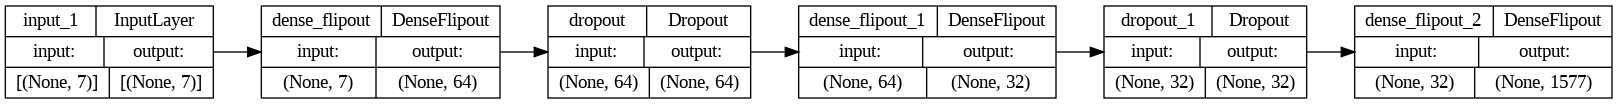

In [23]:
from tensorflow.keras.utils import plot_model

# Plot the model structure and save it to a file
#plot_model(model, to_file='model_structure.png', show_shapes=True, show_layer_names=True)
plot_model(model, to_file='date_bnn_hori.png', show_shapes=True, show_layer_names=True, rankdir='LR')


Accuracy


In [10]:

X_date_test_scaled = tf.convert_to_tensor(X_date_test, dtype=tf.float32)
test_loss, test_accuracy = model.evaluate(X_date_test, y_date_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
train_loss, train_accuracy = model.evaluate(X_date_train, y_date_train)
print(f"Train Accuracy: {train_accuracy:.4f}")

237/237 [==============================] - 3s 8ms/step - loss: 397.8485 - accuracy: 0.5726
Test Accuracy: 0.5726
949/949 [==============================] - 10s 11ms/step - loss: 397.7950 - accuracy: 0.5678
Train Accuracy: 0.5678


In [29]:
from sklearn.metrics import mean_absolute_error
# Make predictions
y_date_pred_train = model.predict(X_date_train_scaled)
# Convert probabilities to predicted classes (point estimate)
y_date_pred_train = np.argmax(y_date_pred_train, axis=1)

mae = mean_absolute_error(y_date_train, y_date_pred_train)
print("Mean Absolute Error (MAE) train:", mae)

mse = mean_squared_error(y_date_train, y_date_pred_train)
print("Mean Absolute Error (MSE) train:", mse)

rmse = np.sqrt(mean_squared_error(y_date_train, y_date_pred_train))
print("Root Mean Squared Error (RMSE) train:", rmse)

y_date_pred_test = model.predict(X_date_test_scaled)
# Convert probabilities to predicted classes (point estimate)
y_date_pred_test = np.argmax(y_date_pred_test, axis=1)
mae_test = mean_absolute_error(y_date_test, y_date_pred_test)
print("Mean Absolute Error (MAE)test:", mae_test)

mse_test = mean_squared_error(y_date_test, y_date_pred_test)
print("Mean Absolute Error (MAE) test:", mse_test)

rmse_test = np.sqrt(mean_squared_error(y_date_test, y_date_pred_test))
print("Root Mean Squared Error (RMSE)test:", rmse_test)


949/949 [==============================] - 6s 6ms/step
Mean Absolute Error (MAE) train: 1.7967859847861165
Mean Absolute Error (MSE) train: 107.1132808640959
Root Mean Squared Error (RMSE) train: 10.34955462153304
237/237 [==============================] - 2s 9ms/step
Mean Absolute Error (MAE)test: 2.096667548267654
Mean Absolute Error (MAE) test: 145.8049457815393
Root Mean Squared Error (RMSE)test: 12.074971874979225


In [12]:
model.save('bnn_date_model.h5')
model.save('my_bnn_model_savedmodel', save_format='tf')

source_path = '/content/my_bnn_model_savedmodel'  # Path to your saved model folder
destination_path = '/content/drive/MyDrive/my_bnn_model_savedmodel'  # Desired path in Google Drive
import shutil
# Copy the folder
shutil.copytree(source_path, destination_path)

FileExistsError: [Errno 17] File exists: '/content/drive/MyDrive/my_bnn_model_savedmodel'